# Machine Learning for Cryptocurrency Trading
## Section 1: Cleaning Raw Data
Raw trading candle data were extracted via GDAX's API and saved as CSV files. In this section, these raw data are cleaned and prepared for price prediction modeling.


In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# Viewing options
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 2000

# from course materials in ~/ml4t
import ml4t  # e.g., ml4t.TradeData()

In [2]:
REPO_PATH = %pwd
DATA_PATH = REPO_PATH + "/data/"
DATA_STARTTIME = '2017-10-01 00:00:00'
DATA_ENDTIME   = '2017-11-30 23:59:59'

In [3]:
# Create second-level index for df based on begining and end or data range
datetimes = pd.date_range(DATA_STARTTIME, DATA_ENDTIME, freq='s')
datetimes[0:10]

DatetimeIndex(['2017-10-01 00:00:00', '2017-10-01 00:00:01',
               '2017-10-01 00:00:02', '2017-10-01 00:00:03',
               '2017-10-01 00:00:04', '2017-10-01 00:00:05',
               '2017-10-01 00:00:06', '2017-10-01 00:00:07',
               '2017-10-01 00:00:08', '2017-10-01 00:00:09'],
              dtype='datetime64[ns]', freq='S')

In [4]:
# Create df with datetimes range as index
df_template = pd.DataFrame(index=datetimes)
df_template.index.name = 'dt'

In [5]:
# Import csv data

# Row names
USDBTC_COLS = ['dt'
               , 'USD-BTC_low'
               , 'USD-BTC_high'
               , 'USD-BTC_open'
               , 'USD-BTC_close'
               , 'USD-BTC_coin_vol']

# Periods of data
PERIODS = ['2017-10', '2017-11']

# USDBTC
df_USDBTC = pd.DataFrame(columns = USDBTC_COLS)

for q in PERIODS:
    df_tmp = pd.read_csv(DATA_PATH + str(q) + '_btc-usd_1sec_candles.csv', header=None)
    df_tmp.columns = USDBTC_COLS
    df_USDBTC = df_USDBTC.append(df_tmp)
del df_tmp
df_USDBTC['dt'] = pd.to_datetime(df_USDBTC['dt'], unit='s')
df_USDBTC = df_USDBTC.set_index('dt')

In [6]:
# Merge data into template df
# Using template ensures df has precise index
df = df_template.join(df_USDBTC)
df.head()

,USD-BTC_low,USD-BTC_high,USD-BTC_open,USD-BTC_close,USD-BTC_coin_vol
dt,,,,,
2017-10-01 00:00:00,4339.01,4339.01,4339.01,4339.01,0.000230
2017-10-01 00:00:01,4339.01,4339.01,4339.01,4339.01,0.069140
2017-10-01 00:00:02,4339.01,4339.01,4339.01,4339.01,0.056691
2017-10-01 00:00:03,NaN,NaN,NaN,NaN,NaN
2017-10-01 00:00:04,NaN,NaN,NaN,NaN,NaN


### Data Exploration

In [7]:
# Density of data
print('Total seconds over time series: {}'.format(df.shape[0]))

# % of seconds with trade
print('% seconds in time series with {} trades: {}'.format('USD-BTC', df['USD-BTC_low'].notna().sum()/df.shape[0]))

Total seconds over time series: 5270400
% seconds in time series with USD-BTC trades: 0.3182128491196114


In [8]:
# % of second candles with >0 volume in which high and low price are NOT the same
# Range of w/i second price variation: (high - low) / low
# Note: the more variation of price w/i a candle, the more likely the USD volume estimate will be incorrect

usd_btc_tmp = df.loc[df['USD-BTC_low'].notna(), ['USD-BTC_low', 'USD-BTC_high']]
usd_btc_tmp['high_low'] = usd_btc_tmp['USD-BTC_low'] == usd_btc_tmp['USD-BTC_high']
usd_btc_tmp['high_low_delta'] = (usd_btc_tmp['USD-BTC_high'] - usd_btc_tmp['USD-BTC_low']) / usd_btc_tmp['USD-BTC_low']
print('% of USD-BTC second trade candles w/ multiple prices : {}'.format(1 - usd_btc_tmp['high_low'].mean()))
print('Max USD-BTC (high - low)/low : {}'.format(usd_btc_tmp['high_low_delta'].max()))
print('Mean USD-BTC (high - low)/low : {}'.format(usd_btc_tmp['high_low_delta'].mean()))

del usd_btc_tmp

% of USD-BTC second trade candles w/ multiple prices : 0.1705625573531595
Max USD-BTC (high - low)/low : 0.08038442308760624
Mean USD-BTC (high - low)/low : 7.391075698540184e-05


Only 31.8% of seconds have trades. Of those seconds with trades, 17.1% have multiple prices within the second. The highest w/i second variation is 8%, but the mean is 0.007%. Large variation is possible when, for instance, a very large market order is placed and in order to fufill the volume the market moves deep into the outstanding limit order book. 

The technique used to calculate the USD volume of a second is (open_price + close_price) / 2 * coin_volume. This should usually be quite accurate given the low variation in prices.

### Clean and Aggregate Data
ml4t.TradeData() is used to clean and aggregare the raw data. ```TradeData.clean_df_s()``` method will perform the following:
 - Fill forward missing data
  - For periods without trades, the low, high, open, and close price are set equal to the most recent closing price. Volume is set to 0.
 - USD volume is calculated as ```(open_price + close_price) / 2 * coin_volume```
 - Period return percentage is calculated as ```(close_price - open_price) / open_price```
 - Aggregations of the data are created as the following attributes of the object:
  - Minute-level: ```TradeData.df_m```
  - Hour-level: ```TradeData.df_h```
  - Day-level: ```TradeData.df_d```

Note: there may be leading NaNs in these series which can cause issues down the line. A note on how many leading NaN periods there are will be printed.

In [9]:
trade_data = ml4t.TradeData(df)
trade_data.clean_df_s()

Note: df has 0 leading NaN periods.
Second-level data have been cleaned and are accessible as .df_s
Minute, hour, and day-level data are available as .df_m, .df_h, and .df_d, respectively.


### Visualizing Data
The ml4t library 

In [16]:
#trade_data.df_m['2017-10-04':'2017-10-06']

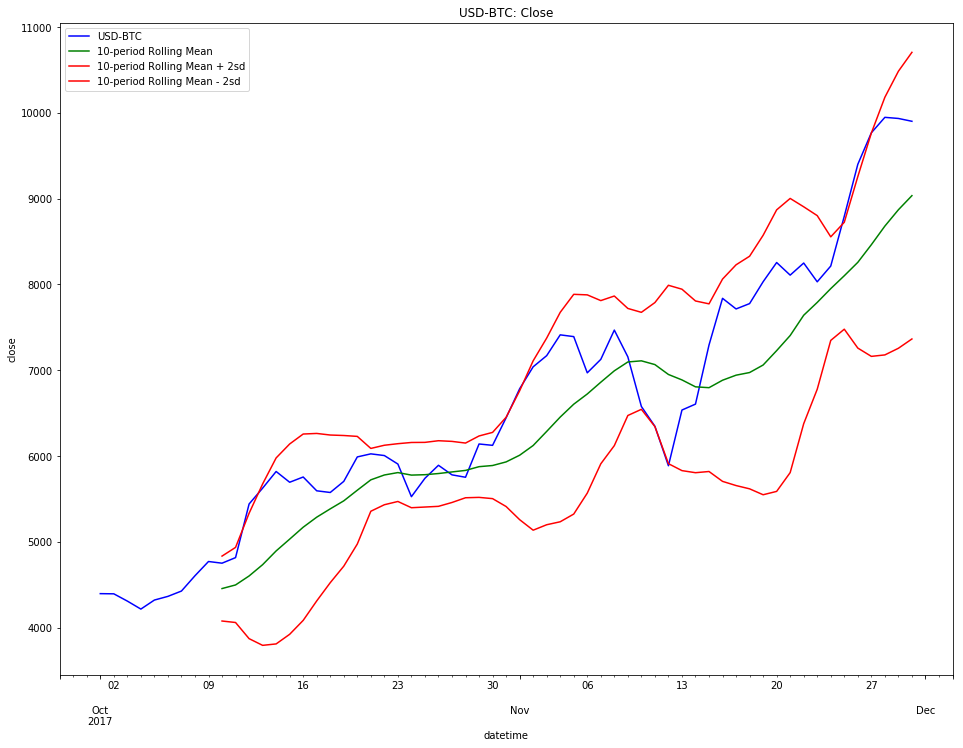

In [18]:
ml4t.plot_rm(trade_data.df_d)